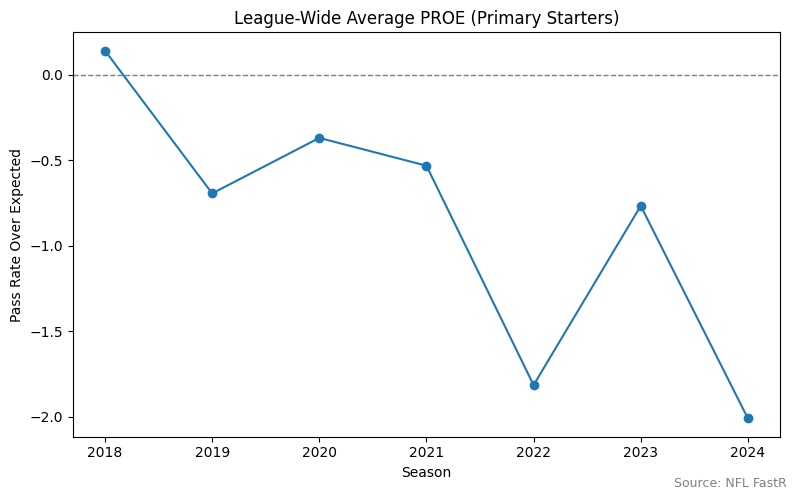

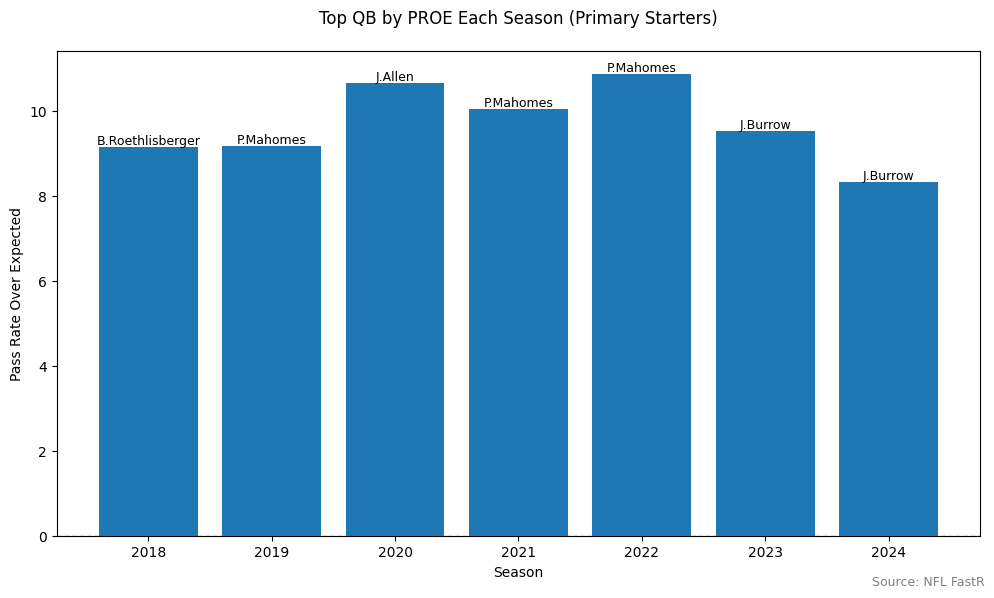

In [54]:
# qb_proe_simple_plots.py
# ------------------------------------------------
# Simple PROE visualizations (Primary Starters)
# ------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

season_csv  = "data/qb_proe_primary_season.csv"
season_agg  = pd.read_csv(season_csv)

def add_source():
    plt.figtext(0.99, 0.01, "Source: NFL FastR",
                ha="right", va="bottom", fontsize=9, color="gray")

# --- 1) League average PROE over time ---
plt.figure(figsize=(8,5))
league_avg = season_agg.groupby("season")["proe"].mean()
plt.plot(league_avg.index, league_avg.values, marker="o")  # default colors
plt.title("League-Wide Average PROE (Primary Starters)")
plt.xlabel("Season")
plt.ylabel("Pass Rate Over Expected")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
add_source()
plt.tight_layout()
plt.show()

# --- 2) Top QB per season ---
top_qbs = (season_agg.sort_values(["season","proe"], ascending=[True,False])
                     .groupby("season").first().reset_index())

plt.figure(figsize=(10,6))
bars = plt.bar(top_qbs["season"], top_qbs["proe"])  # default color

# add QB names directly on the bar tops
for bar, qb in zip(bars, top_qbs["qb_name"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, qb,
             ha="center", va="bottom", fontsize=9)

plt.title("Top QB by PROE Each Season (Primary Starters)", pad=20)
plt.xlabel("Season")
plt.ylabel("Pass Rate Over Expected")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
add_source()
plt.tight_layout()
plt.show()





2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.


C:\Users\PC\AppData\Local\Temp\ipykernel_97360\748386381.py:163: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays["is_game_starter"] = plays["is_game_starter"].fillna(False)


Saved:
  data\qb_primary_starters_by_season.csv
  data\qb_proe_primary_season.csv


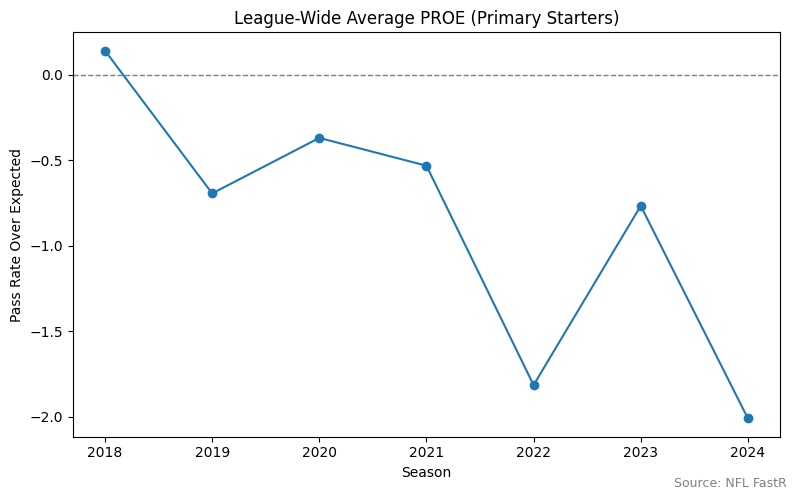

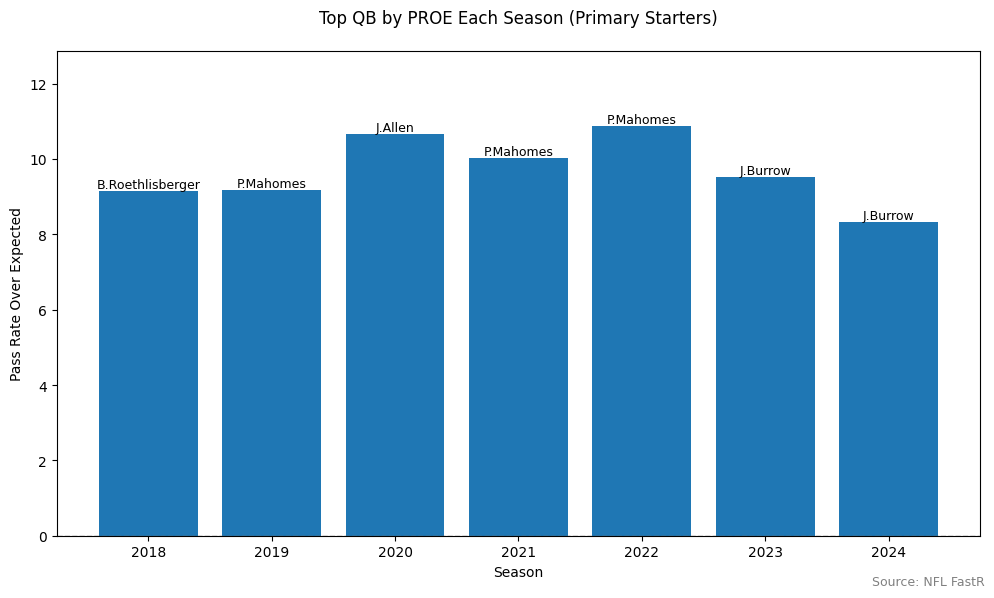

In [55]:
# proe_primary_starters_2018_2024.py
# ------------------------------------------------
# Season PROE for primary starters (2018–2024) + simple plots
# ------------------------------------------------

import os
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import nfl_data_py as nfl

# ------------------ CONFIG ------------------
START_SEASON = 2018
END_SEASON   = 2024
SEASONS: List[int] = list(range(START_SEASON, END_SEASON + 1))
OUT_DIR = "data"
FIG_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------ HELPERS ------------------
def _col(df: pd.DataFrame, name: str, default=0):
    return df[name] if name in df.columns else pd.Series(default, index=df.index)

def filter_play_for_proe(df: pd.DataFrame) -> pd.Series:
    """
    Scrimmage snaps only (pass OR rush), excluding penalties, spikes, kneels, 2-pt tries.
    This matches common PROE filters.
    """
    pass_flag   = _col(df, "pass", 0).fillna(0).astype(int)
    rush_flag   = _col(df, "rush", 0).fillna(0).astype(int)
    penalty     = _col(df, "penalty", 0).fillna(0).astype(int)
    qb_spike    = _col(df, "qb_spike", 0).fillna(0).astype(int)
    qb_kneel    = _col(df, "qb_kneel", 0).fillna(0).astype(int)
    two_point   = _col(df, "two_point_attempt", 0).fillna(0).astype(int)
    posteam_ok  = df["posteam"].notna() if "posteam" in df.columns else False
    scrimmage   = (pass_flag.eq(1) | rush_flag.eq(1))
    return scrimmage & posteam_ok & (penalty.eq(0)) & (qb_spike.eq(0)) & (qb_kneel.eq(0)) & (two_point.eq(0))

def tag_qb_by_passer_ffill(pbp: pd.DataFrame) -> pd.DataFrame:
    """
    Seed QB on dropbacks from passer fields; forward/back-fill within (game_id, posteam)
    so rushes and non-dropback snaps inherit the QB.
    """
    keep = [
        "play_id","game_id","season","week","posteam","defteam","game_date",
        "order_sequence","pass","xpass","pass_oe","qb_dropback","rush",
        "penalty","two_point_attempt","qb_spike","qb_kneel","desc",
        "passer_player_id","passer_player_name","down","goal_to_go","wp",
        "score_differential","quarter_seconds_remaining"
    ]
    keep = [c for c in keep if c in pbp.columns]
    df = pbp[keep].copy()

    # Seed on dropbacks from passer fields (fallback to any passer row if qb_dropback missing)
    if "qb_dropback" in df.columns:
        mask_db = (df["qb_dropback"].fillna(0).astype(int) == 1) & df["passer_player_id"].notna()
    else:
        mask_db = df["passer_player_id"].notna()

    df.loc[mask_db, "qb_id"] = df.loc[mask_db, "passer_player_id"].astype("string")
    df.loc[mask_db, "qb_name"] = df.loc[mask_db, "passer_player_name"]

    # sort + fill
    sort_cols = [c for c in ["game_id","posteam","order_sequence"] if c in df.columns]
    df = df.sort_values(sort_cols, kind="mergesort")
    df["qb_id"]   = df.groupby(["game_id","posteam"])["qb_id"].transform(lambda g: g.ffill().bfill())
    df["qb_name"] = df.groupby(["game_id","posteam"])["qb_name"].transform(lambda g: g.ffill().bfill())

    df = df[df["qb_id"].notna()].copy()
    if "passer_player_id" in df.columns:
        df["passer_player_id"] = df["passer_player_id"].astype("string")
    return df

def identify_game_starters_most_dropbacks(df: pd.DataFrame) -> pd.DataFrame:
    """
    Game starter = QB with most dropbacks for that team in that game (tie → earliest dropback).
    Returns one row per (season, game_id, posteam) with qb_id/qb_name and week.
    """
    if "qb_dropback" not in df.columns:
        raise ValueError("qb_dropback required to determine game starters.")
    db = df[(df["qb_dropback"].fillna(0).astype(int) == 1) & df["qb_id"].notna()].copy()

    counts = (
        db.groupby(["season","game_id","posteam","qb_id","qb_name"], as_index=False)
          .size().rename(columns={"size":"dropbacks"})
    )
    first_db_seq = (
        db.groupby(["season","game_id","posteam","qb_id"], as_index=False)["order_sequence"].min()
          .rename(columns={"order_sequence":"first_db_seq"})
    )
    weeks = df[["season","game_id","posteam","week"]].drop_duplicates()

    cand = (
        counts.merge(first_db_seq, on=["season","game_id","posteam","qb_id"], how="left")
              .merge(weeks, on=["season","game_id","posteam"], how="left")
    )

    starters = (
        cand.sort_values(["season","game_id","posteam","dropbacks","first_db_seq"],
                         ascending=[True, True, True, False, True])
            .groupby(["season","game_id","posteam"], as_index=False)
            .first()[["season","game_id","posteam","week","qb_id","qb_name"]]
    )
    starters["is_game_starter"] = True
    return starters

def identify_primary_starters_by_season(game_starters: pd.DataFrame) -> pd.DataFrame:
    """
    Primary starter per (season, team) = QB with MOST game starts.
    Tie-breakers: earliest first_start_week, then alphabetical qb_name.
    """
    starts = (
        game_starters.groupby(["season","posteam","qb_id","qb_name"], as_index=False)
                     .agg(game_starts=("game_id","nunique"))
    )
    first_week = (
        game_starters.groupby(["season","posteam","qb_id"], as_index=False)["week"].min()
                     .rename(columns={"week":"first_start_week"})
    )
    starts = starts.merge(first_week, on=["season","posteam","qb_id"], how="left")

    primary = (
        starts.sort_values(["season","posteam","game_starts","first_start_week","qb_name"],
                           ascending=[True, True, False, True, True])
              .groupby(["season","posteam"], as_index=False)
              .first()
              .rename(columns={
                  "qb_id":"primary_qb_id",
                  "qb_name":"primary_qb_name",
                  "game_starts":"primary_starts"
              })
    )
    primary["is_primary_season_starter"] = True
    return primary

def add_source():
    """Bottom-right source tag for each figure."""
    plt.figtext(0.99, 0.01, "Source: NFL FastR", ha="right", va="bottom", fontsize=9, color="gray")

# ------------------ MAIN ------------------
def main(seasons: List[int] = SEASONS):
    # 1) Load PBP
    pbp = nfl.import_pbp_data(seasons, downcast=False)

    # 2) Tag QB per play
    plays = tag_qb_by_passer_ffill(pbp)

    # 3) Filter to PROE-eligible snaps + non-null pass_oe
    plays = plays[filter_play_for_proe(plays)].copy()
    plays = plays[plays["pass_oe"].notna()].copy()

    # 4) Game starters → Primary starters
    game_starters = identify_game_starters_most_dropbacks(plays)
    primary = identify_primary_starters_by_season(game_starters)

    # 5) Keep plays where the game starter == that team’s primary season starter
    plays = plays.merge(
        game_starters[["season","game_id","posteam","qb_id","qb_name","is_game_starter"]],
        on=["season","game_id","posteam","qb_id","qb_name"],
        how="left"
    )
    plays["is_game_starter"] = plays["is_game_starter"].fillna(False)

    plays = plays.merge(
        primary[["season","posteam","primary_qb_id","is_primary_season_starter"]],
        on=["season","posteam"],
        how="left"
    )
    plays["is_primary_season_starter"] = plays["is_primary_season_starter"].fillna(False)

    mask_primary_games = (
        plays["is_game_starter"]
        & (plays["qb_id"] == plays["primary_qb_id"])
        & plays["is_primary_season_starter"]
    )
    plays_primary = plays[mask_primary_games].copy()

    # 6) Season-level PROE (play-weighted mean of pass_oe)
    season_agg = (
        plays_primary.groupby(["season","posteam","qb_id","qb_name"], as_index=False)
                     .agg(
                         plays=("play_id","count"),
                         games=("game_id","nunique"),
                         called_pass_rate=("qb_dropback","mean"),  # dropbacks share of snaps
                         expected_pass_rate=("xpass","mean"),
                         proe=("pass_oe","mean"),
                     )
                     .sort_values(["season","posteam"], ascending=[True, True])
    )

    # 7) Save outputs for audit / reuse
    primary_csv = os.path.join(OUT_DIR, "qb_primary_starters_by_season.csv")
    season_csv  = os.path.join(OUT_DIR, "qb_proe_primary_season.csv")
    primary.to_csv(primary_csv, index=False)
    season_agg.to_csv(season_csv, index=False)
    print(f"Saved:\n  {primary_csv}\n  {season_csv}")

    # ------------------ PLOTS ------------------
    # A) League-wide average PROE over time
    plt.figure(figsize=(8,5))
    league_avg = season_agg.groupby("season")["proe"].mean()
    plt.plot(league_avg.index, league_avg.values, marker="o")  # default style
    plt.title("League-Wide Average PROE (Primary Starters)")
    plt.xlabel("Season")
    plt.ylabel("Pass Rate Over Expected")
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    add_source()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "league_avg_proe.png"), dpi=150)
    plt.show()

    # B) Top QB by PROE each season (names on bar tops, horizontal)
    top_qbs = (season_agg.sort_values(["season","proe"], ascending=[True, False])
                         .groupby("season").first().reset_index())

    plt.figure(figsize=(10,6))
    bars = plt.bar(top_qbs["season"], top_qbs["proe"])  # defaults
    # Label names exactly at the bar top
    for bar, qb in zip(bars, top_qbs["qb_name"]):
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h, qb,
                 ha="center", va="bottom", fontsize=9)
    # Give a touch of headroom so names don’t press the frame
    ymax = max(top_qbs["proe"].max() * 1.15, top_qbs["proe"].max() + 2.0)
    plt.ylim(0, ymax)

    plt.title("Top QB by PROE Each Season (Primary Starters)", pad=20)
    plt.xlabel("Season")
    plt.ylabel("Pass Rate Over Expected")
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    add_source()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "top_qb_by_season_proe.png"), dpi=150)
    plt.show()

if __name__ == "__main__":
    main()


In [31]:
# CONFIG — set a metric column if you know it; otherwise leave as None.
# Examples: METRIC_NAME = "PROE" or "+/-" or "CPOE" or "AYTS"
METRIC_NAME = None            # None -> auto-detect ("proe" substring, else "+/-" or CPOE)
INPUT_DIR   = "proe"          # folder with your yearly Excel files (e.g., 2018.xlsx, 2019.xlsx, ...)
OUTPUT_DIR  = "."             # where to write CSVs
TOPN_QB     = 15              # size for top QB table (for your own inspection later)
MIN_ROWS_QB = 3               # min rows required to include a QB in "career" averages

import os, re
from glob import glob
from typing import Optional, Dict, List

import numpy as np
import pandas as pd

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [42]:
def season_from_filename(path: str) -> Optional[int]:
    """Infer season (e.g., 2019) from the filename."""
    m = re.search(r"(20\d{2})", os.path.basename(path))
    return int(m.group(1)) if m else None

def detect_metric_column(df: pd.DataFrame, prefer: Optional[str] = None) -> Optional[str]:
    cols = list(map(str, df.columns))

    # exact preference first
    if prefer and prefer in df.columns:
        return prefer

    # anything containing 'proe'
    for c in cols:
        if "proe" in c.lower().replace(" ", ""):
            return c

    # treat '+/-' as CPOE
    if "+/-" in cols:
        df.rename(columns={"+/-": "CPOE"}, inplace=True)
        return "CPOE"

    # other common cpoe aliases
    for name in ["CPOE", "cpoe", "CPOE%"]:
        if name in df.columns:
            return name

    return None


def guess_text_column(df: pd.DataFrame, candidates_exact: List[str], contains_any: List[str]) -> Optional[str]:
    """Find a reasonable text column for QB or team."""
    low = {c: re.sub(r"\s+", "_", str(c).strip().lower()) for c in df.columns}

    # exact
    for target in candidates_exact:
        for orig, lo in low.items():
            if lo == target:
                return orig

    # contains (substring)
    for needle in contains_any:
        for orig, lo in low.items():
            if needle in lo:
                return orig

    return None


In [43]:
def load_all_excels(in_dir: str) -> List[pd.DataFrame]:
    excel_files = sorted(glob(os.path.join(in_dir, "*.xlsx")))
    if not excel_files:
        raise FileNotFoundError(f"No .xlsx files found in '{in_dir}'.")
    frames = []
    for p in excel_files:
        try:
            xls = pd.ExcelFile(p)
        except Exception as e:
            print(f"[WARN] can't open {p}: {e}")
            continue
        for sheet in xls.sheet_names:
            df = xls.parse(sheet)
            df["__source_file__"] = os.path.basename(p)
            df["__sheet__"] = sheet
            frames.append(df)
    if not frames:
        raise RuntimeError("No readable Excel sheets found.")
    return frames

def normalize_one_sheet(df: pd.DataFrame, metric_hint: Optional[str]) -> pd.DataFrame:
    src = df["__source_file__"].iloc[0]
    season = season_from_filename(src)

    # detect key columns
    qb_col = guess_text_column(
        df,
        candidates_exact=["qb","player","player_name","passer","qb_name","name"],
        contains_any=["player"]  # lenient fallback
    )
    team_col = guess_text_column(
        df,
        candidates_exact=["team","posteam","franchise","club","tm"],
        contains_any=["team"]
    )
    metric_col = detect_metric_column(df, prefer=metric_hint)

    # build numeric metric series
    metric = None
    if metric_col and metric_col in df.columns:
        s = df[metric_col]
        if s.dtype == object:
            s2 = s.astype(str).str.strip().str.replace("%","",regex=False)
            metric = pd.to_numeric(s2, errors="coerce")
            # if values look like whole percentages (mostly >1), convert to fraction
            if metric.notna().any() and (metric.dropna().abs() > 1).mean() > 0.8:
                metric = metric / 100.0
        else:
            metric = pd.to_numeric(s, errors="coerce")

    tidy = pd.DataFrame({
        "season": season,
        "qb": df[qb_col].astype(str).str.strip() if qb_col else pd.Series([None]*len(df)),
        "team": df[team_col].astype(str).str.upper().str.strip() if team_col else pd.Series([None]*len(df)),
        "metric": metric,
        "metric_name": metric_col if metric_col else "(none)",
        "source_file": src,
        "sheet": df["__sheet__"],
    })
    return tidy


In [44]:
frames = load_all_excels(INPUT_DIR)
combined = pd.concat([normalize_one_sheet(df, METRIC_NAME) for df in frames], ignore_index=True)

# validate metric presence
if combined["metric"].notna().sum() == 0:
    # show available columns seen for quick reference
    all_cols_seen = sorted(set(sum([list(map(str, f.columns)) for f in frames], [])))
    raise ValueError(
        "No usable metric found. Set METRIC_NAME to an existing column name "
        "(e.g., 'PROE', '+/-', 'CPOE', 'AYTS').\n\n"
        f"Example columns seen: {all_cols_seen[:30]} ..."
    )

# choose label for downstream
metric_label = (
    combined.loc[combined["metric_name"].notna(), "metric_name"].iloc[0]
    if combined["metric_name"].notna().any()
    else (METRIC_NAME or "Metric")
)

# save combined
combined_out = os.path.join(OUTPUT_DIR, "combined_metric.csv")
combined.to_csv(combined_out, index=False)
print(f"Saved combined tidy data -> {combined_out}")
combined.head(10)


Saved combined tidy data -> .\combined_metric.csv


,season,qb,team,metric,metric_name,source_file,sheet
0,2018,Ben Roethlisberger,PIT,1.1,CPOE,2018.xlsx,Sheet1
1,2018,Patrick Mahomes,KC,2.0,CPOE,2018.xlsx,Sheet1
2,2018,Matt Ryan,ATL,4.7,CPOE,2018.xlsx,Sheet1
3,2018,Jared Goff,LAR,0.6,CPOE,2018.xlsx,Sheet1
4,2018,Andrew Luck,IND,2.0,CPOE,2018.xlsx,Sheet1
5,2018,Aaron Rodgers,GB,-0.5,CPOE,2018.xlsx,Sheet1
6,2018,Tom Brady,NE,-0.9,CPOE,2018.xlsx,Sheet1
7,2018,Philip Rivers,LAC,2.9,CPOE,2018.xlsx,Sheet1
8,2018,Eli Manning,NYG,-1.1,CPOE,2018.xlsx,Sheet1
9,2018,Kirk Cousins,MIN,4.5,CPOE,2018.xlsx,Sheet1


In [45]:
# 1) League average by season
league_by_season = (
    combined.dropna(subset=["metric","season"])
            .groupby("season")["metric"]
            .mean()
            .reset_index(name=f"league_{metric_label}")
)
league_csv = os.path.join(OUTPUT_DIR, "league_metric_by_season.csv")
league_by_season.to_csv(league_csv, index=False)
print(f"Saved -> {league_csv}")

# 2) Best QB per season (by metric mean across that season)
qb_season = (
    combined.dropna(subset=["metric","qb","season"])
            .groupby(["season","qb"])["metric"]
            .mean()
            .reset_index()
)
best_qb_by_season = (
    qb_season.sort_values(["season","metric"], ascending=[True, False])
             .groupby("season")
             .head(1)
             .reset_index(drop=True)
             .rename(columns={"metric": f"best_{metric_label}"})
)
best_csv = os.path.join(OUTPUT_DIR, "best_qb_by_season.csv")
best_qb_by_season.to_csv(best_csv, index=False)
print(f"Saved -> {best_csv}")

# 3) Average by team (across all loaded seasons)
team_metric_avg = (
    combined.dropna(subset=["metric","team"])
            .groupby("team")["metric"]
            .mean()
            .reset_index()
            .sort_values("metric", ascending=False)
            .rename(columns={"metric": f"team_{metric_label}_avg"})
)
team_csv = os.path.join(OUTPUT_DIR, "team_metric_avg.csv")
team_metric_avg.to_csv(team_csv, index=False)
print(f"Saved -> {team_csv}")

# 4) Average by QB across all seasons (career avg), with row-min filter
qb_metric_avg = (
    combined.dropna(subset=["metric","qb"])
            .groupby("qb")["metric"]
            .agg(["mean","count"])
            .reset_index()
            .rename(columns={"mean": f"qb_{metric_label}_avg", "count":"n"})
)
qb_metric_avg = qb_metric_avg.loc[qb_metric_avg["n"] >= MIN_ROWS_QB]\
                             .sort_values(f"qb_{metric_label}_avg", ascending=False)
qb_csv = os.path.join(OUTPUT_DIR, "qb_metric_avg.csv")
qb_metric_avg.to_csv(qb_csv, index=False)
print(f"Saved -> {qb_csv}")


Saved -> .\league_metric_by_season.csv
Saved -> .\best_qb_by_season.csv
Saved -> .\team_metric_avg.csv
Saved -> .\qb_metric_avg.csv


In [46]:
print("\nLeague over time:")
display(league_by_season.head(10))

print("\nBest QB per season:")
display(best_qb_by_season.head(15))

print("\nTop teams by average metric:")
display(team_metric_avg.head(15))

print("\nTop QBs by 'career' average metric:")
display(qb_metric_avg.head(TOPN_QB))



League over time:


,season,league_CPOE
0,2018,0.356410
1,2019,0.087179
2,2020,0.682927
3,2021,-0.776316
4,2022,-0.667500
5,2023,0.126667
6,2024,0.065116



Best QB per season:


,season,qb,best_CPOE
0,2018,Drew Brees,6.8
1,2019,Ryan Tannehill,8.7
2,2020,Ryan Fitzpatrick,7.2
3,2021,Joe Burrow,5.9
4,2022,Mitchell Trubisky,4.7
5,2023,Dak Prescott,5.4
6,2024,Jalen Hurts,6.3



Top teams by average metric:


,team,team_CPOE_avg
21,MIN,3.288889
29,SEA,2.714286
23,NFC,2.600000
17,LAC,1.971429
31,TB,1.585714
27,PHI,1.488889
32,TEN,1.230000
7,CIN,1.190000
20,MIA,1.140000
9,DAL,0.960000



Top QBs by 'career' average metric:


,qb,qb_CPOE_avg,n
32,Drew Brees,4.933333,3
56,Kirk Cousins,4.314286,7
73,Ryan Fitzpatrick,3.666667,3
38,Geno Smith,3.433333,3
47,Joe Burrow,3.260000,5
71,Philip Rivers,3.100000,3
23,Dak Prescott,2.985714,7
74,Ryan Tannehill,2.616667,6
63,Matt Ryan,2.260000,5
27,Derek Carr,2.171429,7


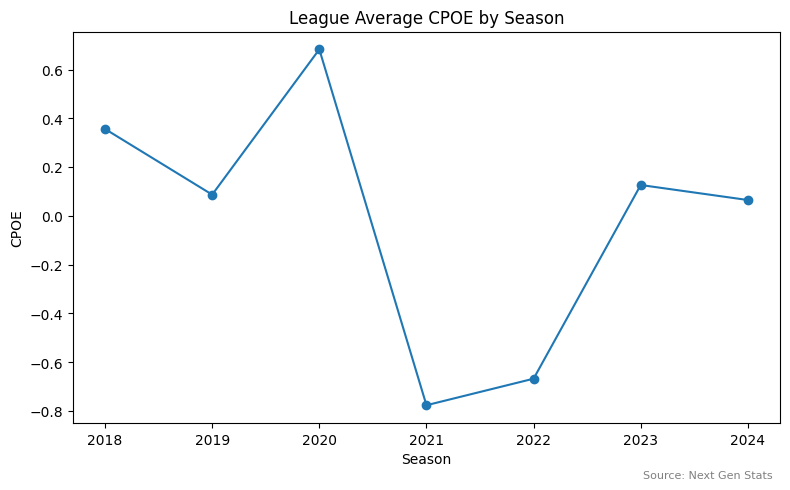

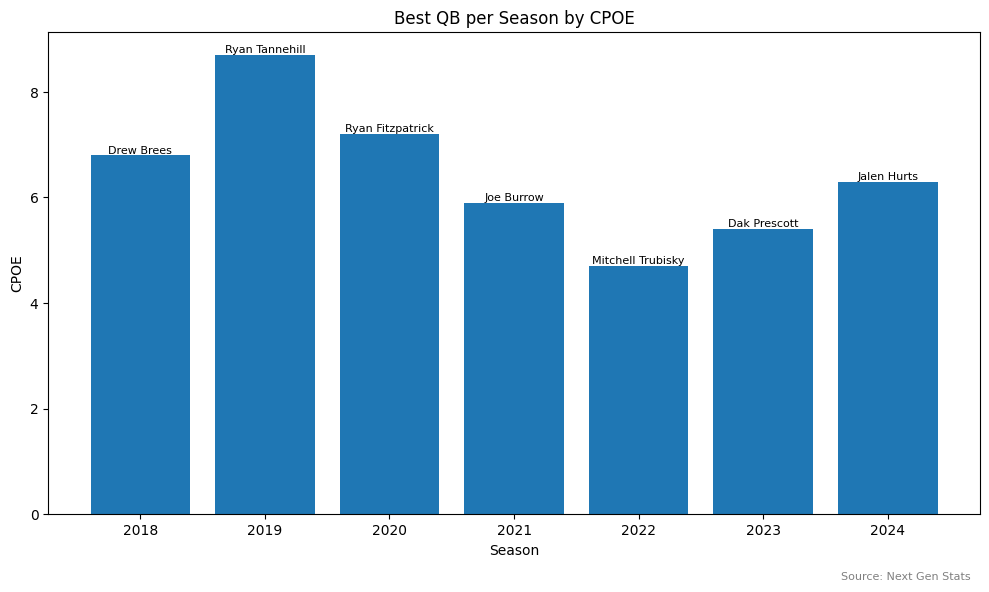

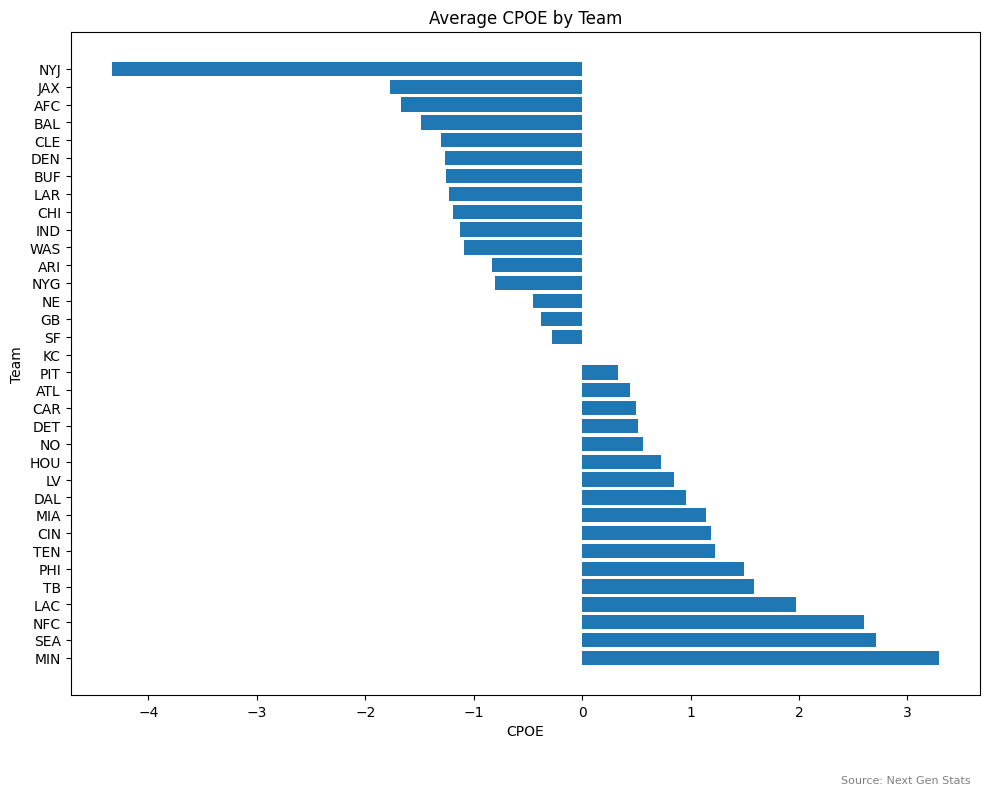

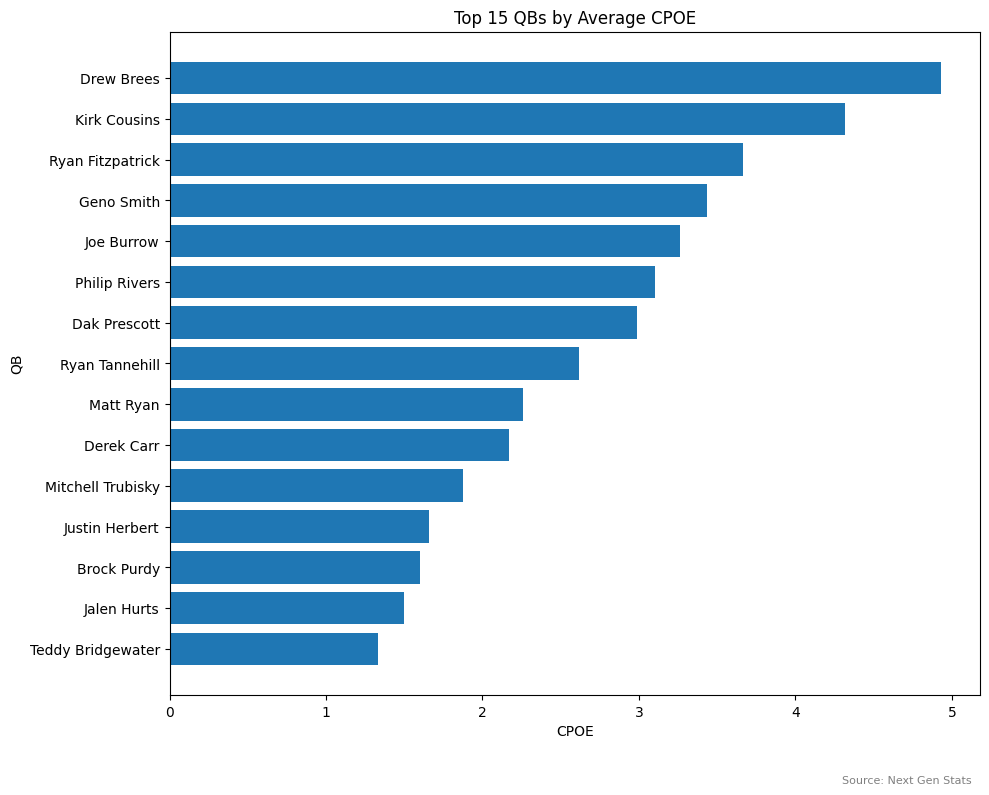

In [56]:
import matplotlib.pyplot as plt

def add_source_note(text="Source: Next Gen Stats"):
    """helper to add source note in bottom right of current axes."""
    plt.gca().text(
        0.99, -0.12, text,
        ha="right", va="top", transform=plt.gca().transAxes,
        fontsize=8, color="gray"
    )

# 1) league average metric by season
plt.figure(figsize=(8,5))
plt.plot(league_by_season["season"], league_by_season[f"league_{metric_label}"], marker="o")
plt.title(f"League Average {metric_label} by Season")
plt.xlabel("Season")
plt.ylabel(metric_label)
add_source_note()
plt.tight_layout()
plt.show()

# 2) best qb each season
plt.figure(figsize=(10,6))
plt.bar(best_qb_by_season["season"], best_qb_by_season[f"best_{metric_label}"])
for xi, yi, lab in zip(best_qb_by_season["season"], best_qb_by_season[f"best_{metric_label}"], best_qb_by_season["qb"]):
    plt.text(xi, yi, str(lab), ha="center", va="bottom", fontsize=8)
plt.title(f"Best QB per Season by {metric_label}")
plt.xlabel("Season")
plt.ylabel(metric_label)
add_source_note()
plt.tight_layout()
plt.show()

# 3) average by team (barh)
plt.figure(figsize=(10,8))
plt.barh(team_metric_avg["team"], team_metric_avg[f"team_{metric_label}_avg"])
plt.title(f"Average {metric_label} by Team")
plt.xlabel(metric_label)
plt.ylabel("Team")
add_source_note()
plt.tight_layout()
plt.show()

# 4) average by qb (top N)
plt.figure(figsize=(10,8))
top_qb = qb_metric_avg.head(TOPN_QB).iloc[::-1]
plt.barh(top_qb["qb"], top_qb[f"qb_{metric_label}_avg"])
plt.title(f"Top {TOPN_QB} QBs by Average {metric_label}")
plt.xlabel(metric_label)
plt.ylabel("QB")
add_source_note()
plt.tight_layout()
plt.show()


Loading PBP from nflfastR (2005–2024)...
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.


C:\Users\PC\AppData\Local\Temp\ipykernel_10424\2859891416.py:165: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays["is_game_starter"] = plays["is_game_starter"].fillna(False)


Saved:
  data\qb_proe_primary_season_2005_2024.csv
  data\qb_primary_starters_by_season_2005_2024.csv


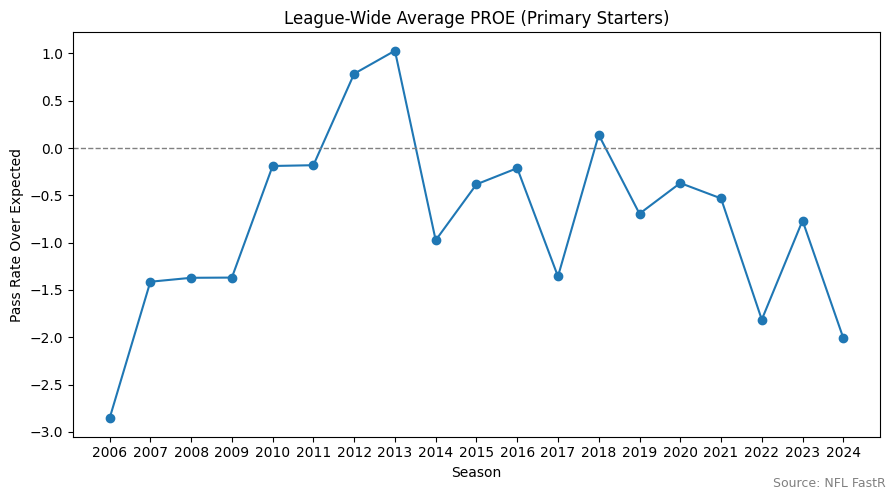

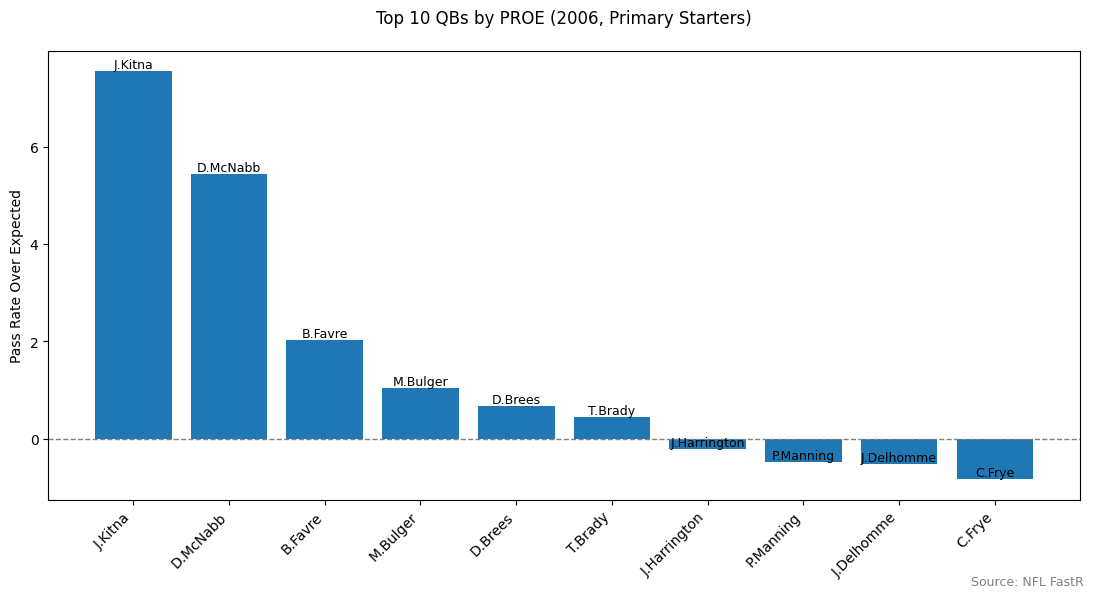

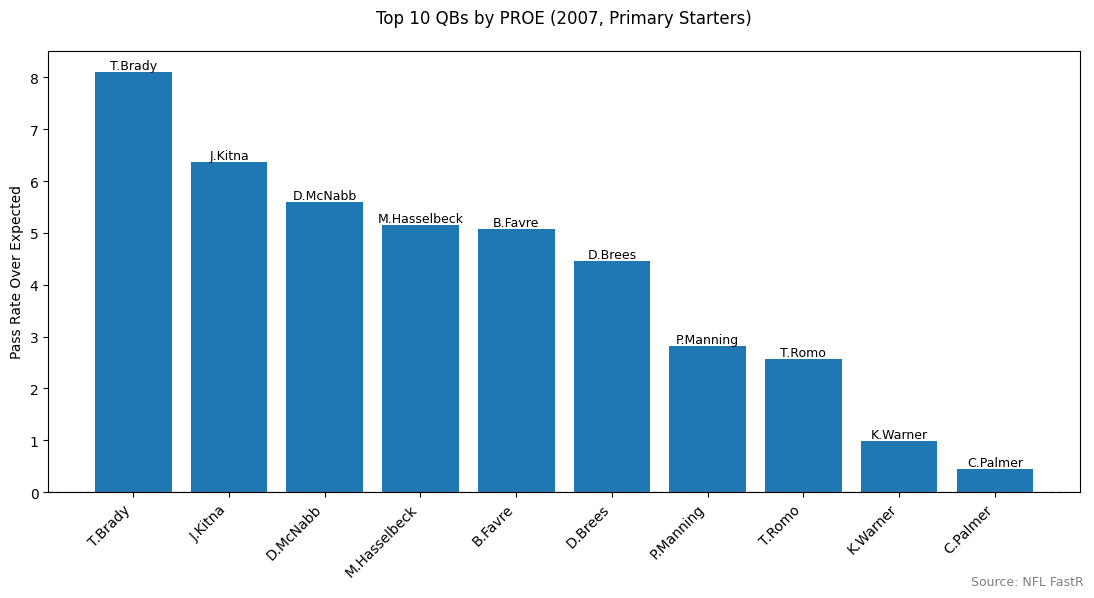

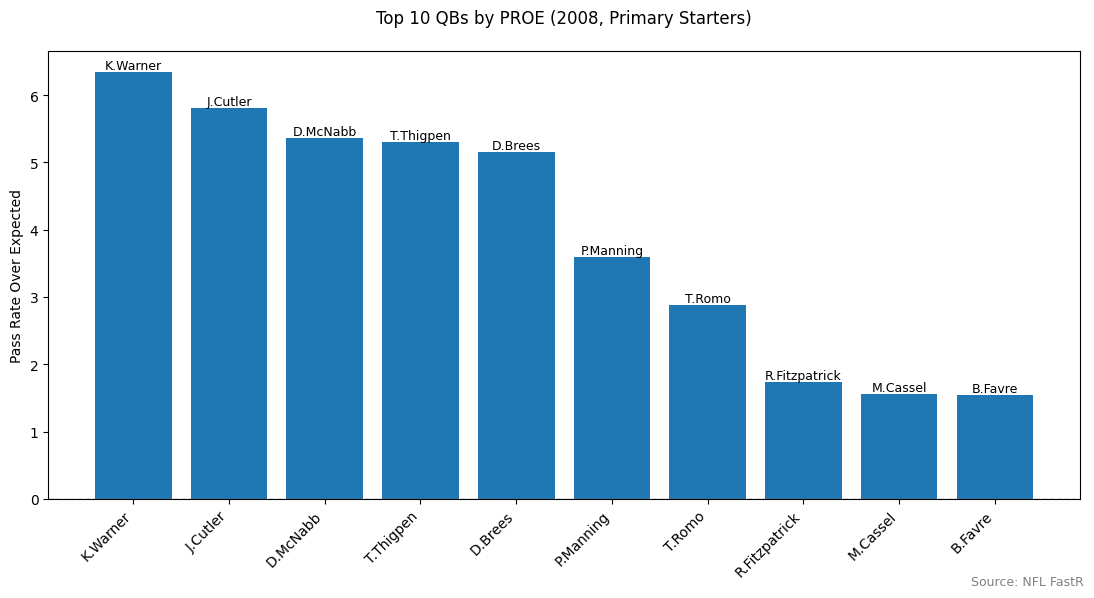

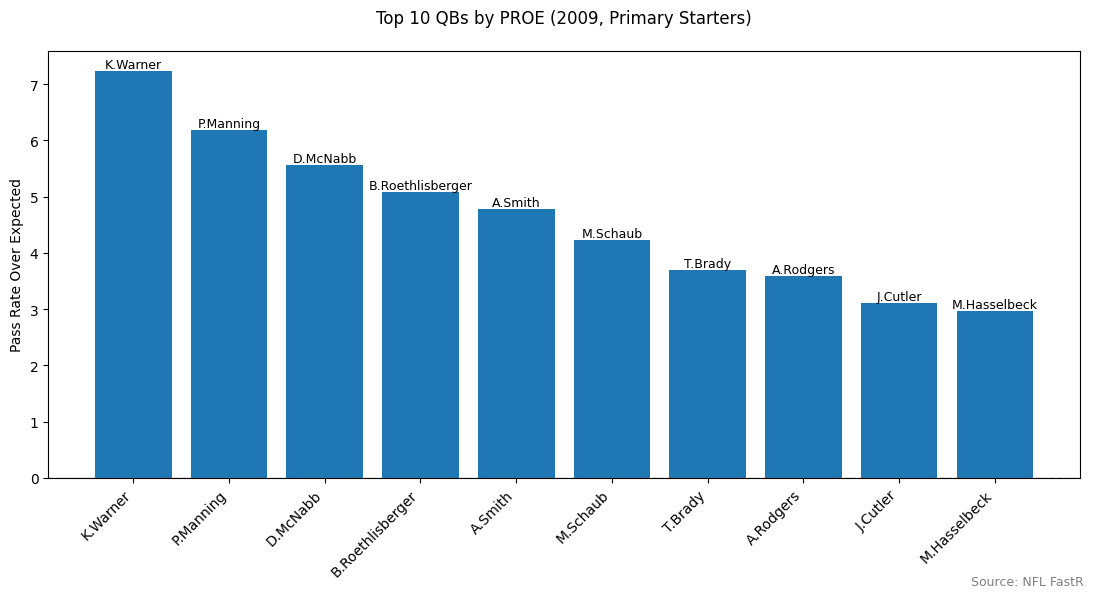

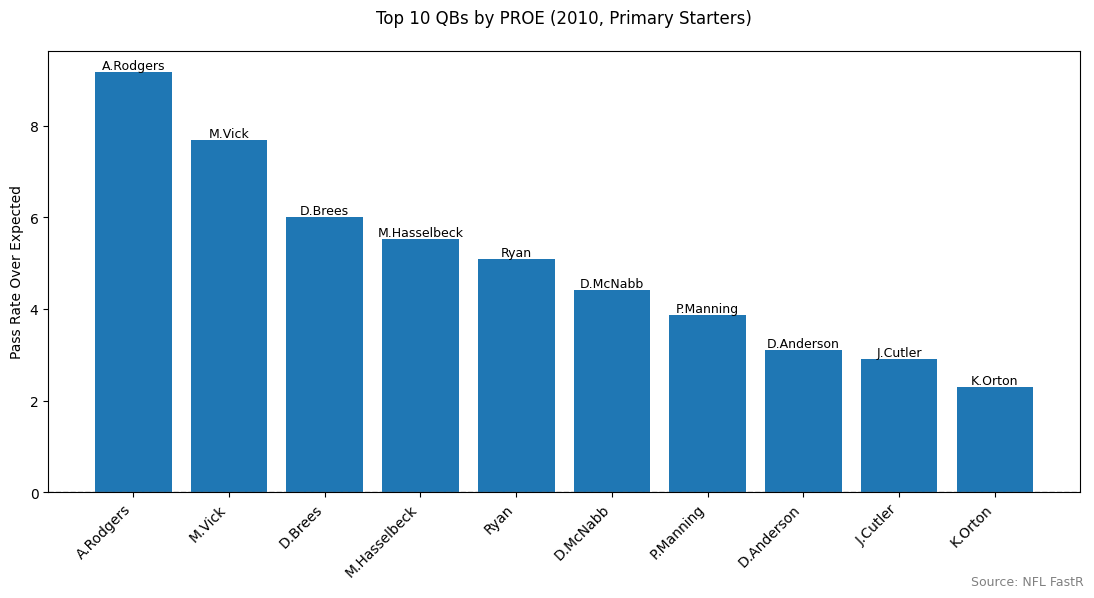

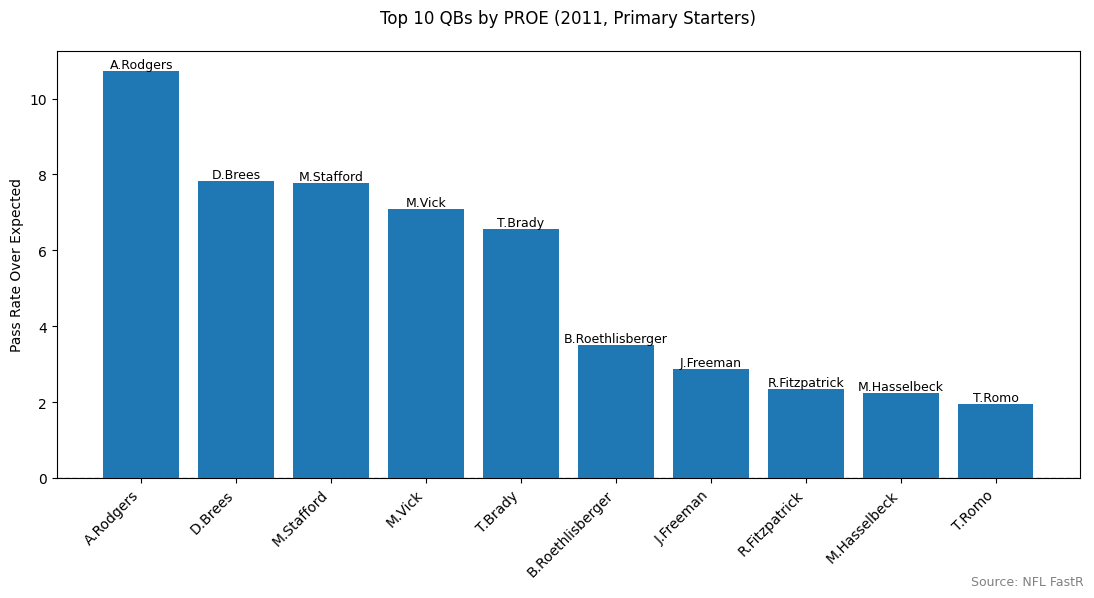

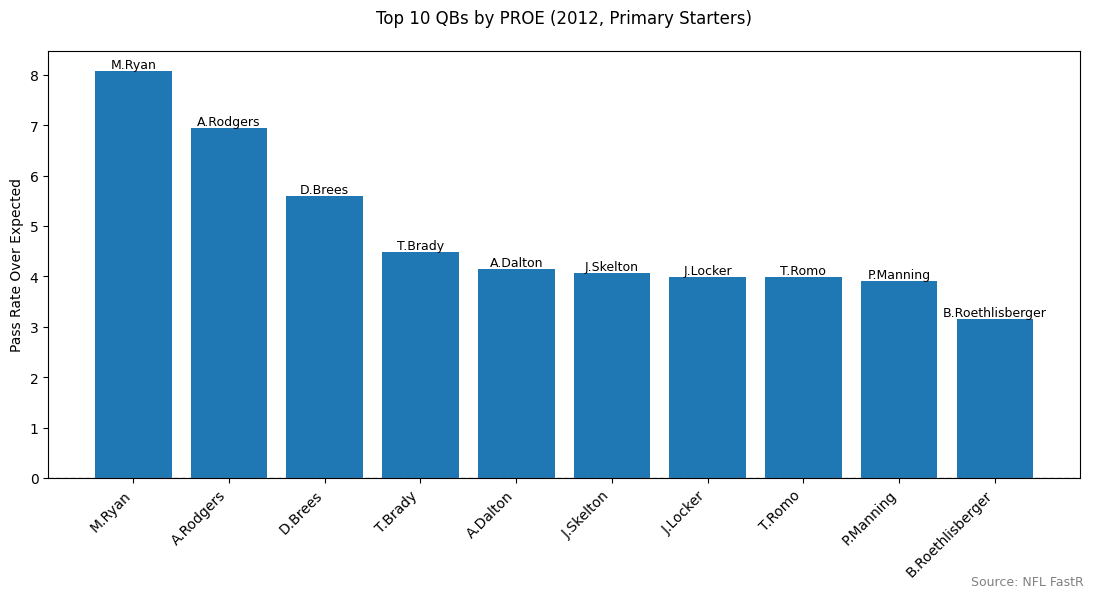

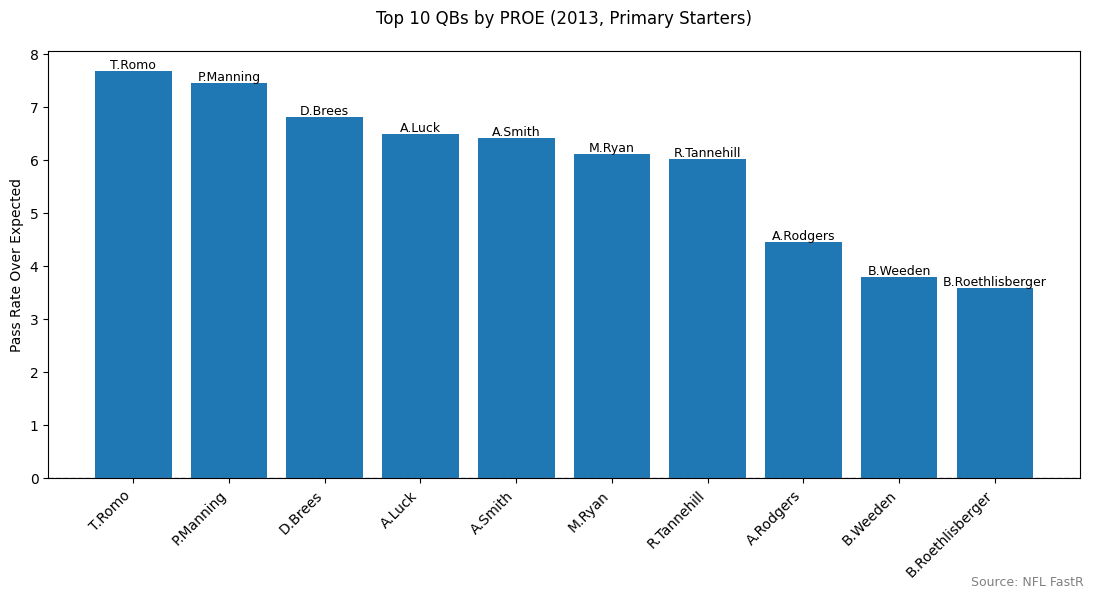

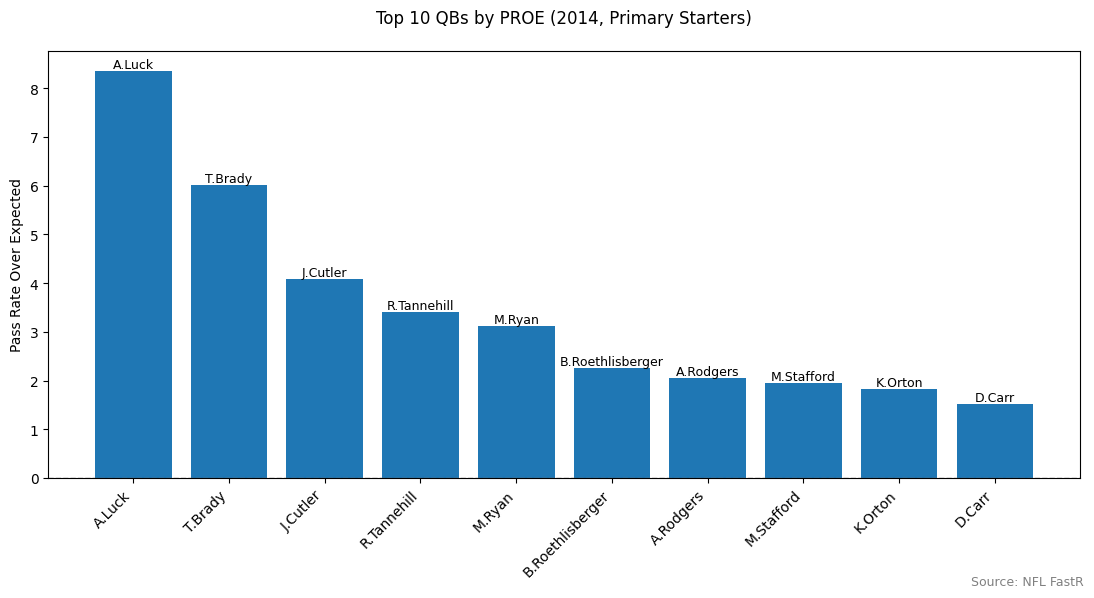

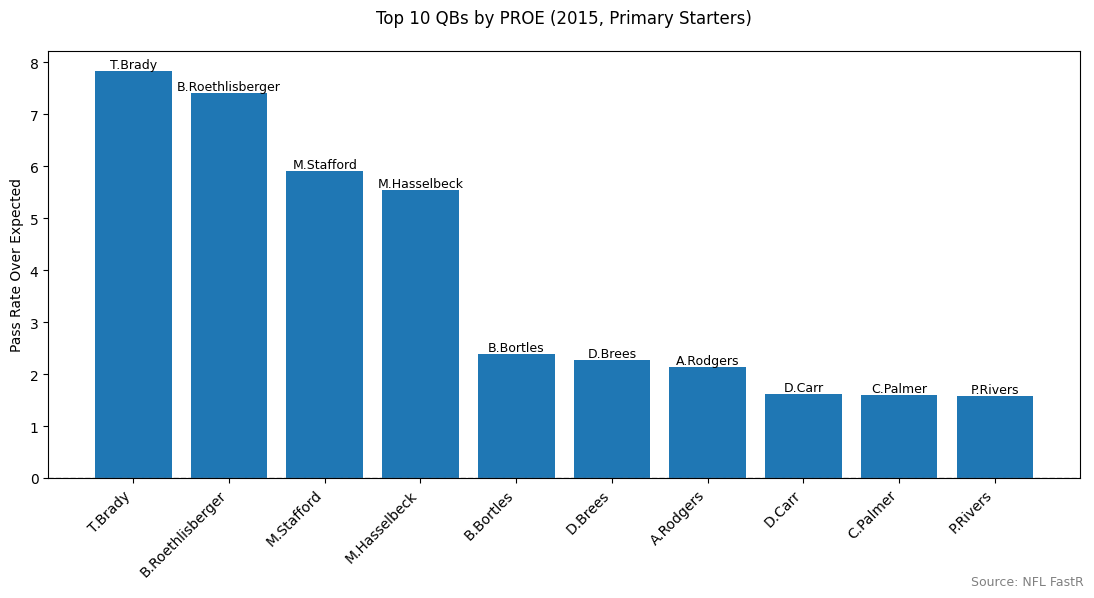

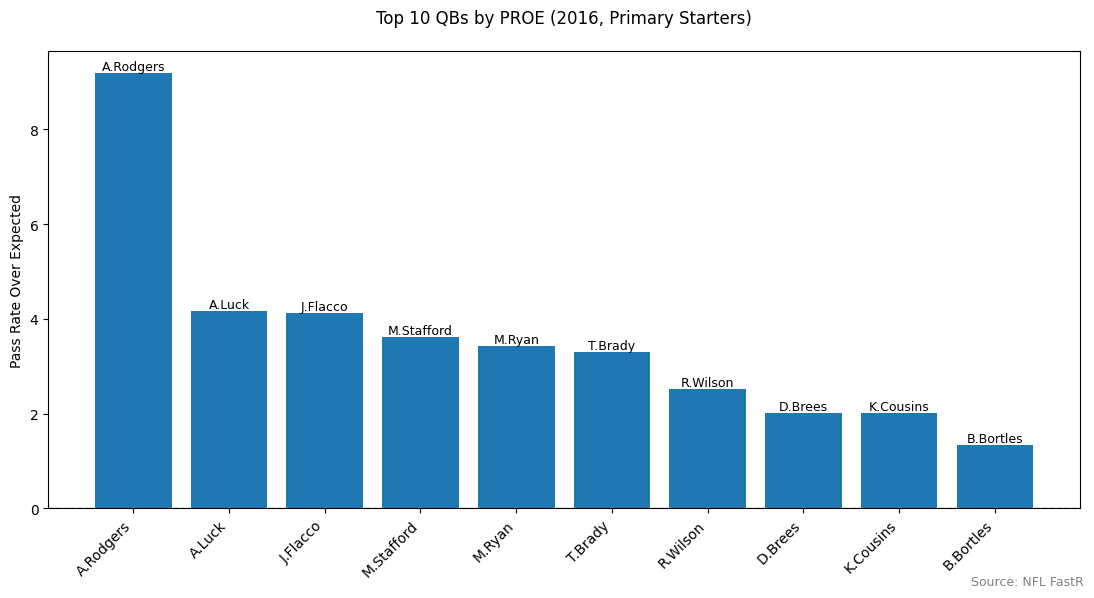

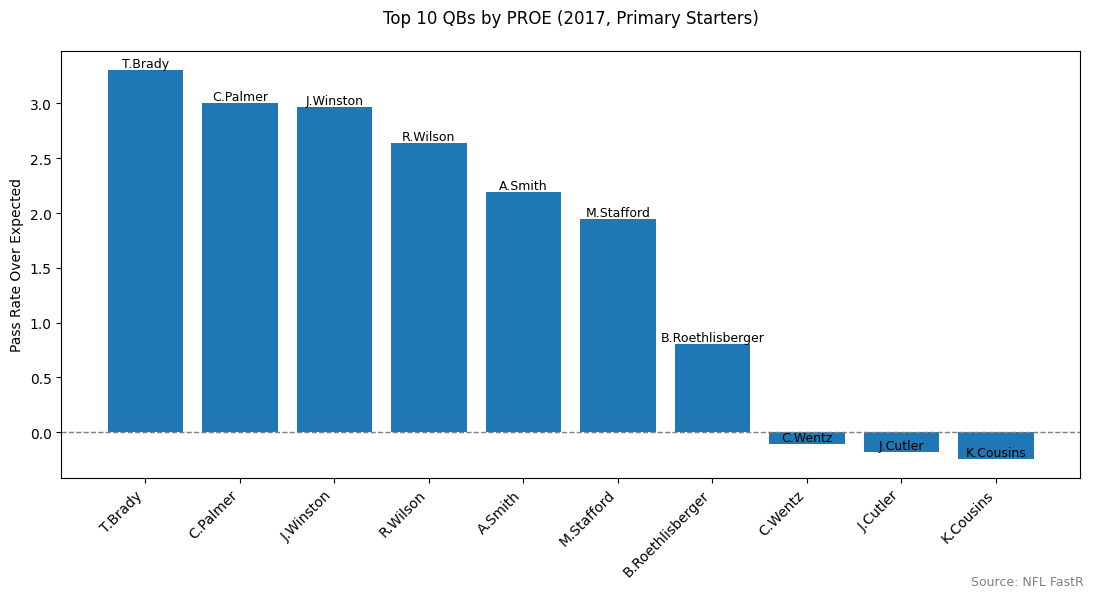

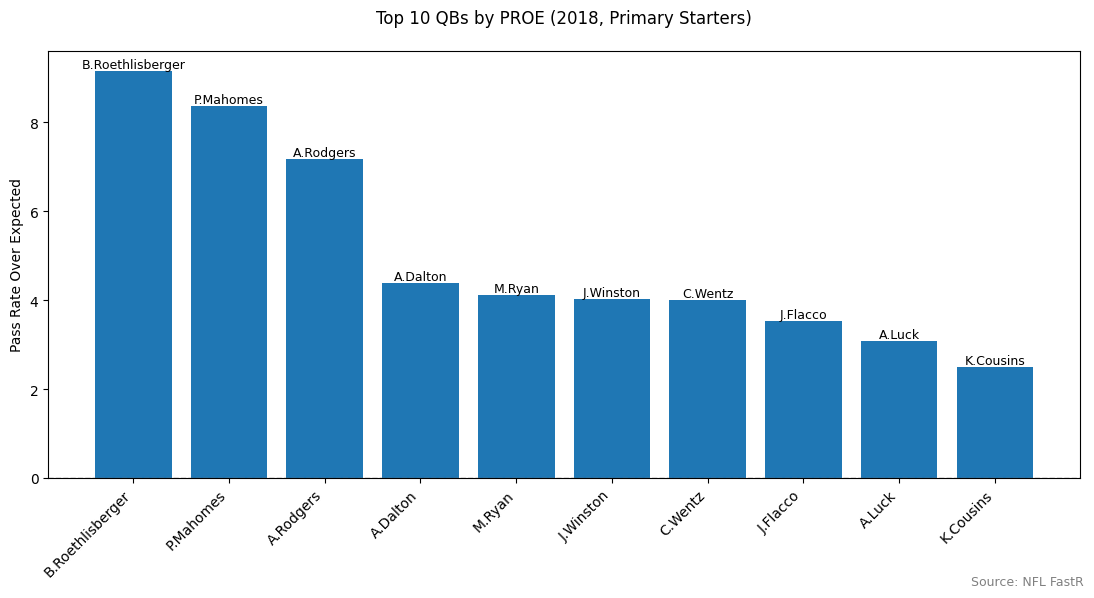

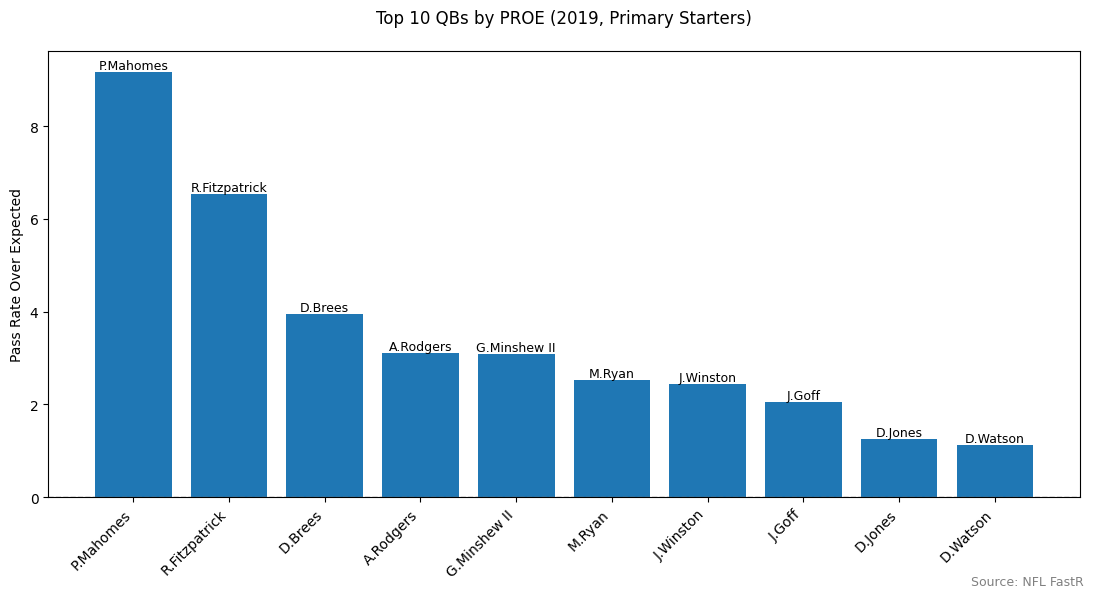

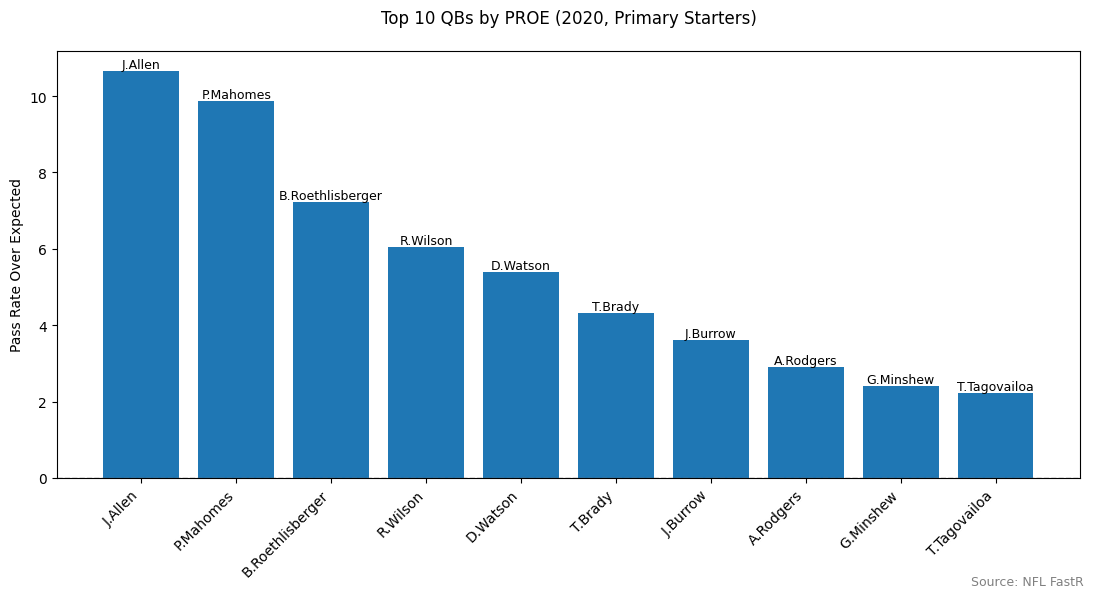

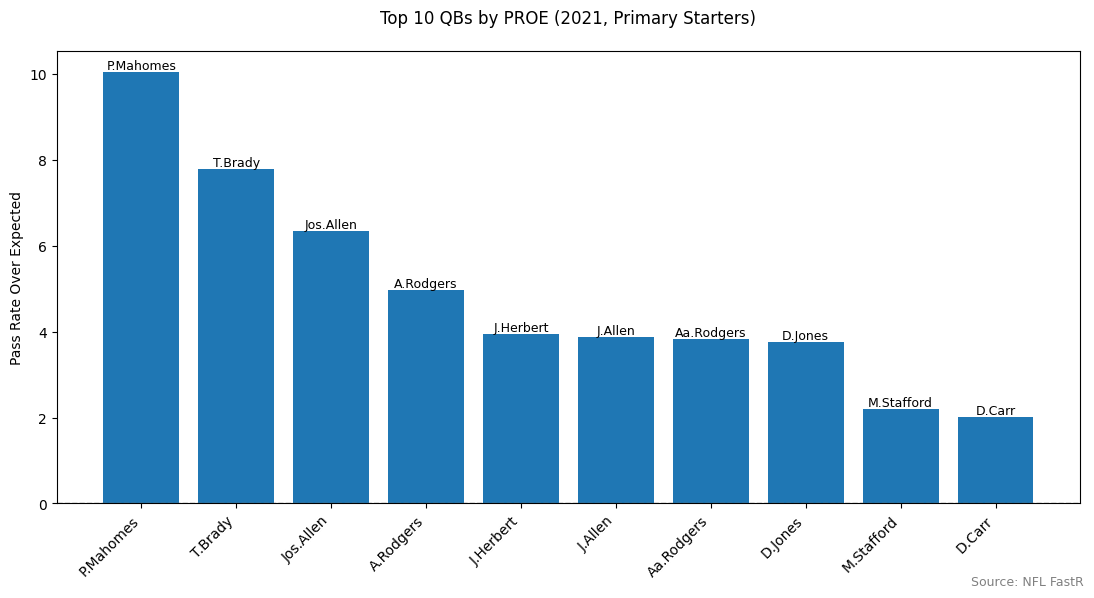

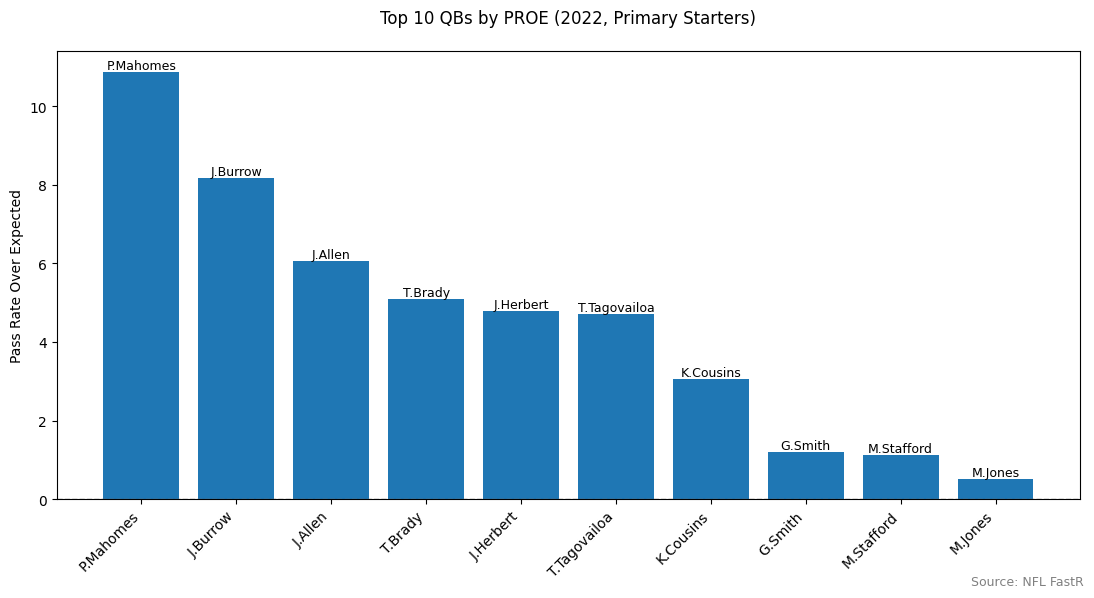

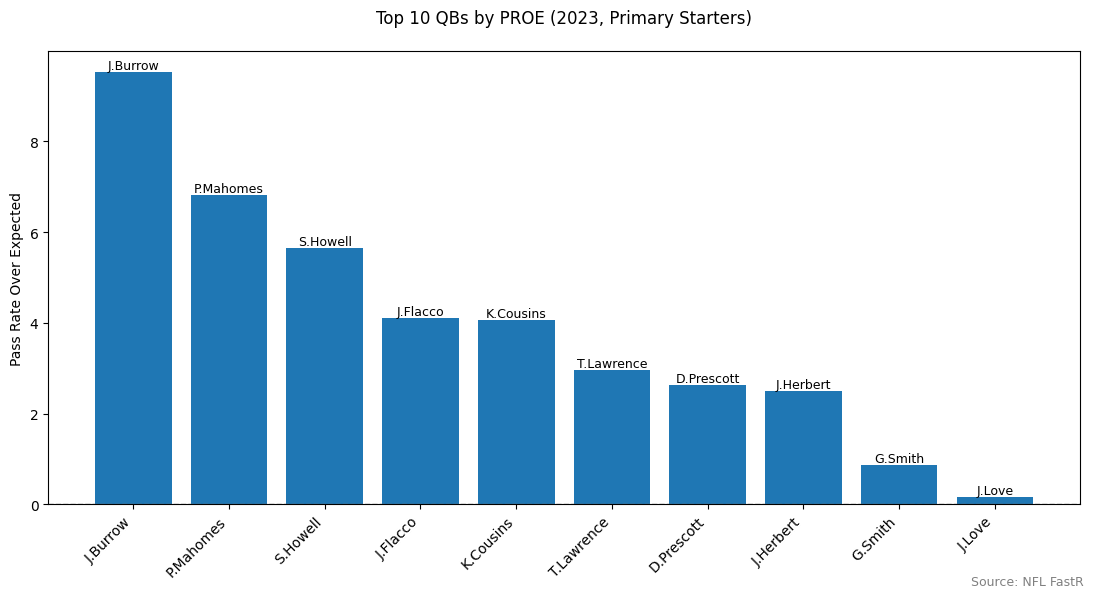

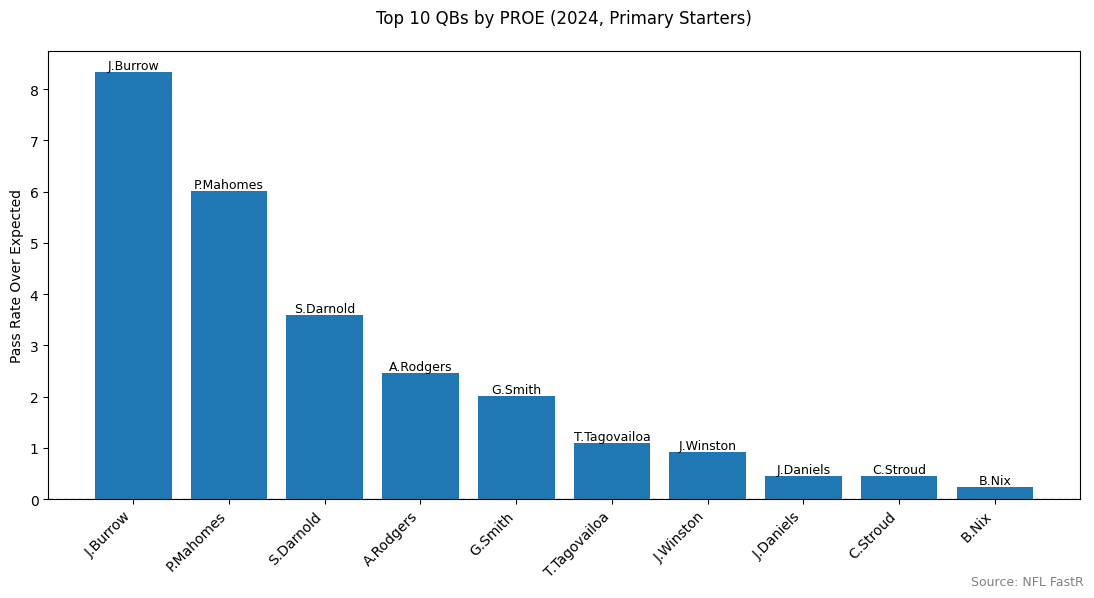

In [3]:
# proe_primary_starters_2005_2024.py
# ------------------------------------------------
# Season PROE for primary starters (2005–2024) + plots
# ------------------------------------------------

import os
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import nfl_data_py as nfl

# ------------------ CONFIG ------------------
START_SEASON = 2005
END_SEASON   = 2024
SEASONS: List[int] = list(range(START_SEASON, END_SEASON + 1))

OUT_DIR = "data"
FIG_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------ HELPERS ------------------
def _col(df: pd.DataFrame, name: str, default=0):
    return df[name] if name in df.columns else pd.Series(default, index=df.index)

def filter_play_for_proe(df: pd.DataFrame) -> pd.Series:
    """
    Scrimmage snaps only (pass OR rush), excluding penalties, spikes, kneels, 2-pt tries.
    This matches common PROE filters.
    """
    pass_flag   = _col(df, "pass", 0).fillna(0).astype(int)
    rush_flag   = _col(df, "rush", 0).fillna(0).astype(int)
    penalty     = _col(df, "penalty", 0).fillna(0).astype(int)
    qb_spike    = _col(df, "qb_spike", 0).fillna(0).astype(int)
    qb_kneel    = _col(df, "qb_kneel", 0).fillna(0).astype(int)
    two_point   = _col(df, "two_point_attempt", 0).fillna(0).astype(int)
    posteam_ok  = df["posteam"].notna() if "posteam" in df.columns else False
    scrimmage   = (pass_flag.eq(1) | rush_flag.eq(1))
    return scrimmage & posteam_ok & (penalty.eq(0)) & (qb_spike.eq(0)) & (qb_kneel.eq(0)) & (two_point.eq(0))

def tag_qb_by_passer_ffill(pbp: pd.DataFrame) -> pd.DataFrame:
    """
    Seed QB on dropbacks from passer fields; forward/back-fill within (game_id, posteam)
    so rushes and non-dropback snaps inherit the QB.
    """
    keep = [
        "play_id","game_id","season","week","posteam","defteam","game_date",
        "order_sequence","pass","xpass","pass_oe","qb_dropback","rush",
        "penalty","two_point_attempt","qb_spike","qb_kneel","desc",
        "passer_player_id","passer_player_name"
    ]
    keep = [c for c in keep if c in pbp.columns]
    df = pbp[keep].copy()

    # Seed on dropbacks from passer fields (fallback to any passer row if qb_dropback missing)
    if "qb_dropback" in df.columns:
        mask_db = (df["qb_dropback"].fillna(0).astype(int) == 1) & df["passer_player_id"].notna()
    else:
        mask_db = df["passer_player_id"].notna()

    df.loc[mask_db, "qb_id"] = df.loc[mask_db, "passer_player_id"].astype("string")
    df.loc[mask_db, "qb_name"] = df.loc[mask_db, "passer_player_name"]

    # sort + fill
    sort_cols = [c for c in ["game_id","posteam","order_sequence"] if c in df.columns]
    df = df.sort_values(sort_cols, kind="mergesort")
    df["qb_id"]   = df.groupby(["game_id","posteam"])["qb_id"].transform(lambda g: g.ffill().bfill())
    df["qb_name"] = df.groupby(["game_id","posteam"])["qb_name"].transform(lambda g: g.ffill().bfill())

    df = df[df["qb_id"].notna()].copy()
    if "passer_player_id" in df.columns:
        df["passer_player_id"] = df["passer_player_id"].astype("string")
    return df

def identify_game_starters_most_dropbacks(df: pd.DataFrame) -> pd.DataFrame:
    """
    Game starter = QB with most dropbacks for that team in that game (tie → earliest dropback).
    Returns one row per (season, game_id, posteam) with qb_id/qb_name and week.
    """
    if "qb_dropback" not in df.columns:
        raise ValueError("qb_dropback required to determine game starters.")
    db = df[(df["qb_dropback"].fillna(0).astype(int) == 1) & df["qb_id"].notna()].copy()

    counts = (
        db.groupby(["season","game_id","posteam","qb_id","qb_name"], as_index=False)
          .size().rename(columns={"size":"dropbacks"})
    )
    first_db_seq = (
        db.groupby(["season","game_id","posteam","qb_id"], as_index=False)["order_sequence"].min()
          .rename(columns={"order_sequence":"first_db_seq"})
    )
    weeks = df[["season","game_id","posteam","week"]].drop_duplicates()

    cand = (
        counts.merge(first_db_seq, on=["season","game_id","posteam","qb_id"], how="left")
              .merge(weeks, on=["season","game_id","posteam"], how="left")
    )

    starters = (
        cand.sort_values(["season","game_id","posteam","dropbacks","first_db_seq"],
                         ascending=[True, True, True, False, True])
            .groupby(["season","game_id","posteam"], as_index=False)
            .first()[["season","game_id","posteam","week","qb_id","qb_name"]]
    )
    starters["is_game_starter"] = True
    return starters

def identify_primary_starters_by_season(game_starters: pd.DataFrame) -> pd.DataFrame:
    """
    Primary starter per (season, team) = QB with MOST game starts.
    Tie-breakers: earliest first_start_week, then alphabetical qb_name.
    """
    starts = (
        game_starters.groupby(["season","posteam","qb_id","qb_name"], as_index=False)
                     .agg(game_starts=("game_id","nunique"))
    )
    first_week = (
        game_starters.groupby(["season","posteam","qb_id"], as_index=False)["week"].min()
                     .rename(columns={"week":"first_start_week"})
    )
    starts = starts.merge(first_week, on=["season","posteam","qb_id"], how="left")

    primary = (
        starts.sort_values(["season","posteam","game_starts","first_start_week","qb_name"],
                           ascending=[True, True, False, True, True])
              .groupby(["season","posteam"], as_index=False)
              .first()
              .rename(columns={
                  "qb_id":"primary_qb_id",
                  "qb_name":"primary_qb_name",
                  "game_starts":"primary_starts"
              })
    )
    primary["is_primary_season_starter"] = True
    return primary

def add_source():
    """Bottom-right source tag for each figure."""
    plt.figtext(0.99, 0.01, "Source: NFL FastR", ha="right", va="bottom", fontsize=9, color="gray")

# ------------------ MAIN ------------------
def main():
    # 1) Load PBP
    print(f"Loading PBP from nflfastR ({START_SEASON}–{END_SEASON})...")
    pbp = nfl.import_pbp_data(SEASONS, downcast=False)

    # 2) Tag QB per play
    plays = tag_qb_by_passer_ffill(pbp)

    # 3) Filter to PROE-eligible snaps + non-null pass_oe
    plays = plays[filter_play_for_proe(plays)].copy()
    plays = plays[plays["pass_oe"].notna()].copy()

    # 4) Game starters → Primary starters
    game_starters = identify_game_starters_most_dropbacks(plays)
    primary = identify_primary_starters_by_season(game_starters)

    # 5) Keep plays where the game starter == that team’s primary season starter
    plays = plays.merge(
        game_starters[["season","game_id","posteam","qb_id","qb_name","is_game_starter"]],
        on=["season","game_id","posteam","qb_id","qb_name"],
        how="left"
    )
    plays["is_game_starter"] = plays["is_game_starter"].fillna(False)

    plays = plays.merge(
        primary[["season","posteam","primary_qb_id","is_primary_season_starter"]],
        on=["season","posteam"],
        how="left"
    )
    plays["is_primary_season_starter"] = plays["is_primary_season_starter"].fillna(False)

    mask_primary_games = (
        plays["is_game_starter"]
        & (plays["qb_id"] == plays["primary_qb_id"])
        & plays["is_primary_season_starter"]
    )
    plays_primary = plays[mask_primary_games].copy()

    # 6) Season-level PROE (play-weighted mean of pass_oe across ALL scrimmage snaps)
    season_agg = (
        plays_primary.groupby(["season","posteam","qb_id","qb_name"], as_index=False)
                     .agg(
                         plays=("play_id","count"),
                         games=("game_id","nunique"),
                         raw_pass_rate=("pass","mean"),        # actual pass share
                         expected_pass_rate=("xpass","mean"),  # expected pass share
                         proe=("pass_oe","mean"),              # actual - expected
                     )
                     .sort_values(["season","posteam"], ascending=[True, True])
    )

    # Save aggregated data (optional but handy)
    season_csv  = os.path.join(OUT_DIR, "qb_proe_primary_season_2005_2024.csv")
    primary_csv = os.path.join(OUT_DIR, "qb_primary_starters_by_season_2005_2024.csv")
    season_agg.to_csv(season_csv, index=False)
    primary.to_csv(primary_csv, index=False)
    print(f"Saved:\n  {season_csv}\n  {primary_csv}")

    # ------------------ PLOTS ------------------
    # A) League-wide average PROE over time (force integer x-ticks)
    plt.figure(figsize=(9,5))
    league_avg = season_agg.groupby("season", as_index=True)["proe"].mean()
    plt.plot(league_avg.index, league_avg.values, marker="o")
    plt.title("League-Wide Average PROE (Primary Starters)")
    plt.xlabel("Season")
    plt.ylabel("Pass Rate Over Expected")
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))     # <- years as integers
    plt.xticks(list(league_avg.index))                        # <- ticks exactly at seasons
    add_source()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "league_avg_proe_2005_2024.png"), dpi=150)
    plt.show()

    # B) Top 10 QBs by PROE per season (labels on bar tops; integer titles)
    top10 = (
        season_agg.sort_values(["season","proe"], ascending=[True, False])
                  .groupby("season")
                  .head(10)
    )

    for season, df in top10.groupby("season"):
        plt.figure(figsize=(11,6))
        bars = plt.bar(df["qb_name"], df["proe"])
        # names on bar tops (horizontal)
        for bar, qb in zip(bars, df["qb_name"]):
            h = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, h, qb, ha="center", va="bottom", fontsize=9)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Top 10 QBs by PROE ({int(season)}, Primary Starters)", pad=20)  # ensure integer in title
        plt.ylabel("Pass Rate Over Expected")
        plt.axhline(0, color="gray", linestyle="--", linewidth=1)
        add_source()
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"top10_qbs_proe_{int(season)}.png"), dpi=150)
        plt.show()

if __name__ == "__main__":
    main()


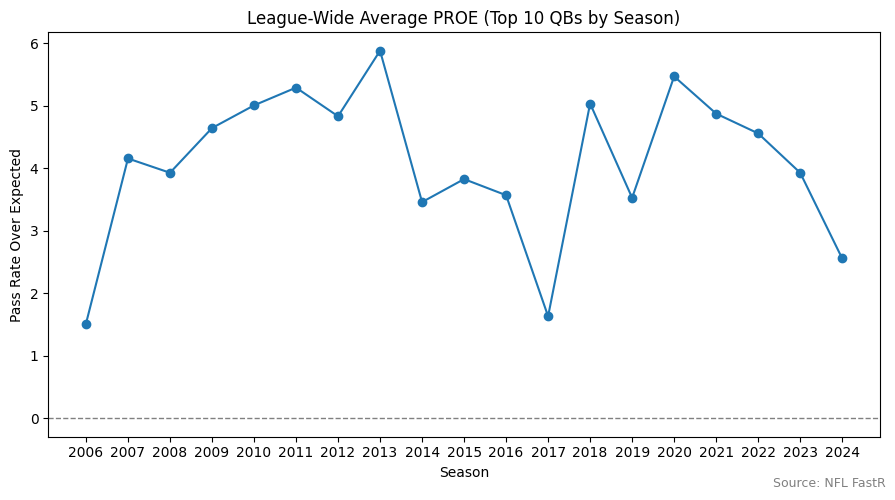

In [5]:
# --- League-wide average PROE (Top 10 QBs per season only) ---
top10 = (
    season_agg.sort_values(["season","proe"], ascending=[True, False])
              .groupby("season")
              .head(10)  # top 10 QBs each season
)

plt.figure(figsize=(9,5))
league_avg_top10 = top10.groupby("season", as_index=True)["proe"].mean()
plt.plot(league_avg_top10.index, league_avg_top10.values, marker="o")
plt.title("League-Wide Average PROE (Top 10 QBs by Season)")
plt.xlabel("Season")
plt.ylabel("Pass Rate Over Expected")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

# force integer ticks
plt.xticks(list(league_avg_top10.index))

add_source()
plt.tight_layout()
plt.show()


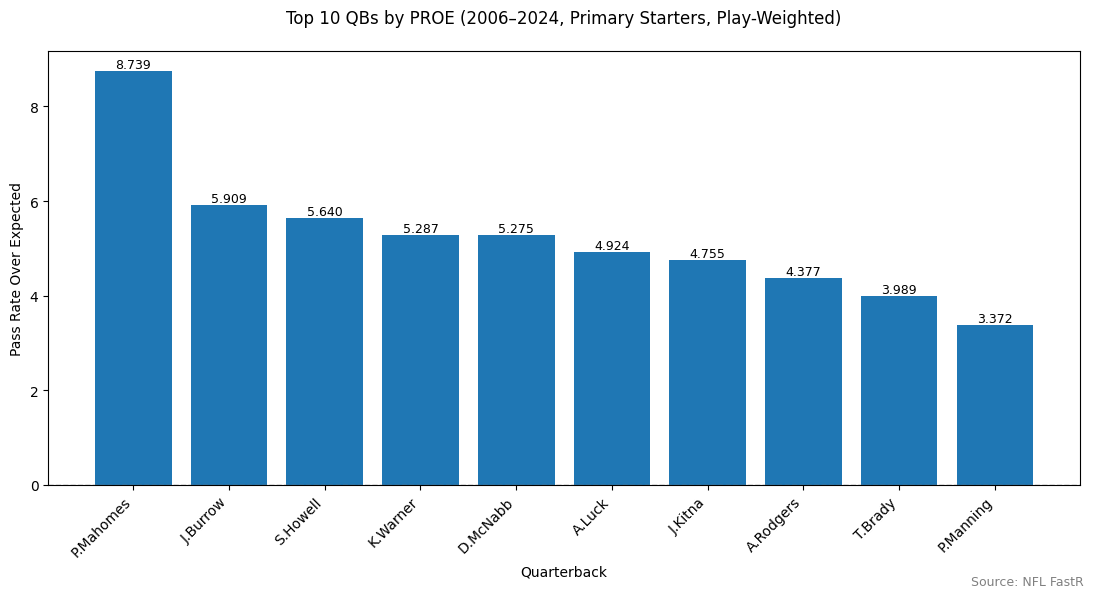

In [6]:
# overall_top10_qbs_proe.py
# ------------------------------------------------
# Top 10 QBs by PROE across the full window (play-weighted)
# Uses season-level file from your pipeline, or a season_agg DataFrame in memory.
# ------------------------------------------------

import os
import pandas as pd
import matplotlib.pyplot as plt

SEASON_CSV = "data/qb_proe_primary_season_2005_2024.csv"  # produced by your main script
MIN_GAMES = 16   # tweak if you want a floor (e.g., 16 games ~ 1 season)
MIN_PLAYS = 800  # tweak if you want a play-count floor

def add_source():
    plt.figtext(0.99, 0.01, "Source: NFL FastR", ha="right", va="bottom", fontsize=9, color="gray")

# --- Load season aggregates (or reuse your in-memory season_agg) ---
if 'season_agg' not in globals():
    if not os.path.exists(SEASON_CSV):
        raise FileNotFoundError(f"Couldn't find {SEASON_CSV}. Run your main script first.")
    season_agg = pd.read_csv(SEASON_CSV)

# nflfastR pass_oe exists from 2006 onward; keep those seasons
season_agg = season_agg[season_agg["season"] >= 2006].copy()

# --- Build overall, play-weighted PROE per QB across all seasons ---
tmp = season_agg.copy()
tmp["proe_x_plays"] = tmp["proe"] * tmp["plays"]

overall = (
    tmp.groupby(["qb_id","qb_name"], as_index=False)
       .agg(
           total_plays=("plays","sum"),
           total_games=("games","sum"),
           sum_proe_x_plays=("proe_x_plays","sum"),
       )
)
overall["proe_weighted"] = overall["sum_proe_x_plays"] / overall["total_plays"]

# Optional stability filters
overall = overall[(overall["total_games"] >= MIN_GAMES) & (overall["total_plays"] >= MIN_PLAYS)]

# Top 10 by play-weighted PROE
top10 = overall.sort_values("proe_weighted", ascending=False).head(10).reset_index(drop=True)

# --- Plot: Top 10 QBs overall (2006–2024) ---
plt.figure(figsize=(11,6))
bars = plt.bar(top10["qb_name"], top10["proe_weighted"])  # default color

# labels right on the bar tops (numeric value)
for bar, val in zip(bars, top10["proe_weighted"]):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{val:.3f}", ha="center", va="bottom", fontsize=9)

plt.title("Top 10 QBs by PROE (2006–2024, Primary Starters, Play-Weighted)", pad=20)
plt.xlabel("Quarterback")
plt.ylabel("Pass Rate Over Expected")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xticks(rotation=45, ha="right")
add_source()
plt.tight_layout()
plt.show()
